# RQ2 — Preparación del subset salarial

Para responder RQ2 ("¿Se mantiene la asociación entre modalidad de trabajo y salario al controlar por país, experiencia, educación y rol?"),
necesitamos trabajar con la **población efectiva de análisis salarial**.

En el dataset, `ConvertedCompYearly` presenta ≈ 64.19% de valores faltantes, y por construcción `log_salary = log(1 + ConvertedCompYearly)`
hereda el mismo missingness. Por ello, el análisis salarial se interpreta **solo** sobre participantes que reportaron salario.

En este notebook (RQ2) construiremos el subset mínimo:

- `has_salary == True`  (equivale a `ConvertedCompYearly` no nulo)
- `RemoteWork` no nulo

Luego (en pasos posteriores del notebook) haremos un filtro más estricto para el modelo ajustado, exigiendo también `Country`,
`YearsCodePro_num`, `EdLevel` y `DevType` disponibles.

> Nota: el dataset procesado oficial ya incluye variables derivadas como `has_salary`, `YearsCodePro_num` y `log_salary`,
pero las recalculamos de forma defensiva por reproducibilidad.


In [17]:
import pandas as pd
import numpy as np

# =============== CARGA (ajusta la ruta a tu CSV procesado) ===============
df = pd.read_csv("../data/processed/df_final_v1.csv")

# (Opcional) vistazo rápido
display(df.head())
print("Shape original:", df.shape)


,ResponseId,MainBranch,Employment,Country,RemoteWork,ConvertedCompYearly,YearsCodePro,YearsCode,DevType,EdLevel,Age,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,WebframeHaveWorkedWith,PlatformHaveWorkedWith,ToolsTechHaveWorkedWith,has_salary,YearsCodePro_num,log_salary
0,1,I am a developer by profession,"Employed, full-time",United States of America,Remote,NaN,NaN,NaN,NaN,Primary/elementary school,Under 18 years old,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",United Kingdom of Great Britain and Northern I...,Remote,NaN,17,20,"Developer, full-stack","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",35-44 years old,NaN,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Dynamodb;MongoDB;PostgreSQL,Express;Next.js;Node.js;React,Amazon Web Services (AWS);Heroku;Netlify,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,False,17.0,NaN
2,3,I am a developer by profession,"Employed, full-time",United Kingdom of Great Britain and Northern I...,Remote,NaN,27,37,Developer Experience,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",45-54 years old,NaN,C#,Firebase Realtime Database,ASP.NET CORE,Google Cloud,MSBuild,False,27.0,NaN
3,4,I am learning to code,"Student, full-time",Canada,NaN,NaN,NaN,4,"Developer, full-stack",Some college/university study without earning ...,18-24 years old,NaN,C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...,MongoDB;MySQL;PostgreSQL;SQLite,jQuery;Next.js;Node.js;React;WordPress,Amazon Web Services (AWS);Fly.io;Heroku,Docker;npm;Pip,False,NaN,NaN
4,5,I am a developer by profession,"Student, full-time",Norway,NaN,NaN,NaN,9,"Developer, full-stack","Secondary school (e.g. American high school, G...",18-24 years old,NaN,C++;HTML/CSS;JavaScript;Lua;Python;Rust,PostgreSQL;SQLite,NaN,NaN,APT;Make;npm,False,NaN,NaN


Shape original: (65437, 20)


In [18]:

# =============== VALIDACIÓN DE COLUMNAS MÍNIMAS PARA RQ2 ===============
required_cols = ["ConvertedCompYearly", "RemoteWork"]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas necesarias para RQ2: {missing_cols}")

# =============== VARIABLES DERIVADAS (defensivo) ===============
# has_salary: indicador de disponibilidad de salario
if "has_salary" not in df.columns:
    df["has_salary"] = df["ConvertedCompYearly"].notna()

# log_salary: log(1 + salary)
if "log_salary" not in df.columns:
    df["log_salary"] = np.log1p(df["ConvertedCompYearly"])

# YearsCodePro_num: si no existe, intenta crearlo (no lo usamos aún en PASO 2, pero lo dejamos listo)
if "YearsCodePro_num" not in df.columns and "YearsCodePro" in df.columns:
    tmp = df["YearsCodePro"].replace({
        "Less than 1 year": "0.5",
        "More than 50 years": "51"
    })
    df["YearsCodePro_num"] = pd.to_numeric(tmp, errors="coerce")

# =============== REPORTE DE MISSINGNESS CLAVE ===============
salary_missing = df["ConvertedCompYearly"].isna().mean() * 100
rw_missing = df["RemoteWork"].isna().mean() * 100
print(f"Missing ConvertedCompYearly: {salary_missing:.2f}%")
print(f"Missing RemoteWork: {rw_missing:.2f}%")

# =============== SUBSET MÍNIMO PARA RQ2 (SALARIO + MODALIDAD) ===============
df_rq2_base = df[df["has_salary"] & df["RemoteWork"].notna()].copy()

print("\n--- Subset RQ2 (mínimo) ---")
print("Shape subset:", df_rq2_base.shape)
print(f"% filas retenidas: {100*len(df_rq2_base)/len(df):.2f}%")

print("\nDistribución de RemoteWork en el subset:")
print(df_rq2_base["RemoteWork"].value_counts())

counts = df_rq2_base["RemoteWork"].value_counts(dropna=False)
props = (counts / counts.sum()).round(4)

dist = pd.DataFrame({"count": counts, "prop": props})
dist

Missing ConvertedCompYearly: 64.19%
Missing RemoteWork: 16.25%

--- Subset RQ2 (mínimo) ---
Shape subset: (23427, 20)
% filas retenidas: 35.80%

Distribución de RemoteWork en el subset:
RemoteWork
Hybrid (some remote, some in-person)    9899
Remote                                  9591
In-person                               3937
Name: count, dtype: int64


,count,prop
RemoteWork,,
"Hybrid (some remote, some in-person)",9899,0.4225
Remote,9591,0.4094
In-person,3937,0.1681


In [19]:
pd.crosstab(df_rq2_base["Country"], df_rq2_base["RemoteWork"]).head()



RemoteWork,"Hybrid (some remote, some in-person)",In-person,Remote
Country,,,
Afghanistan,3,5,4
Albania,3,2,6
Algeria,4,1,5
Andorra,0,1,1
Angola,1,1,1


In [20]:
pd.crosstab(df_rq2_base["DevType"], df_rq2_base["RemoteWork"]).head()

RemoteWork,"Hybrid (some remote, some in-person)",In-person,Remote
DevType,,,
Academic researcher,226,117,53
Blockchain,17,7,68
Cloud infrastructure engineer,118,21,147
Data engineer,280,63,236
Data or business analyst,106,44,52


In [21]:

RW_HYB = "Hybrid (some remote, some in-person)"
RW_INP = "In-person"
RW_REM = "Remote"

ct_country = pd.crosstab(df_rq2_base["Country"], df_rq2_base["RemoteWork"])

# Asegurar columnas aunque alguna no exista (por seguridad)
for col in [RW_HYB, RW_INP, RW_REM]:
    if col not in ct_country.columns:
        ct_country[col] = 0

ct_country["total"] = ct_country[[RW_HYB, RW_INP, RW_REM]].sum(axis=1)
ct_country["in_person_share"] = ct_country[RW_INP] / ct_country["total"]

ct_country_sorted = ct_country.sort_values("total", ascending=False)

ct_country_sorted.head(20)


RemoteWork,"Hybrid (some remote, some in-person)",In-person,Remote,total,in_person_share
Country,,,,,
United States of America,1592,650,2434,4676,0.139008
Germany,1183,287,575,2045,0.140342
Ukraine,305,58,1111,1474,0.039349
United Kingdom of Great Britain and Northern Ireland,661,134,595,1390,0.096403
India,396,355,286,1037,0.342334
France,552,158,208,918,0.172113
Canada,309,92,468,869,0.105869
Brazil,166,104,415,685,0.151825
Poland,201,47,338,586,0.080205


In [22]:
# cuenta cuántas modalidades tienen al menos 1 caso
ct_country_sorted["n_modalities_present"] = (
    (ct_country_sorted[[RW_HYB, RW_INP, RW_REM]] > 0).sum(axis=1)
)

ct_country_sorted["n_modalities_present"].value_counts()


n_modalities_present
3    114
2     27
1     25
Name: count, dtype: int64

In [23]:
MIN_TOTAL = 100
MIN_INPERSON = 20

good_countries = ct_country_sorted[
    (ct_country_sorted["total"] >= MIN_TOTAL) &
    (ct_country_sorted[RW_INP] >= MIN_INPERSON) &
    (ct_country_sorted["n_modalities_present"] == 3)
].index

df_rq2_country_ok = df_rq2_base[df_rq2_base["Country"].isin(good_countries)].copy()

print("Países retenidos:", len(good_countries))
print("Filas antes:", len(df_rq2_base))
print("Filas después:", len(df_rq2_country_ok))

df_rq2_country_ok["RemoteWork"].value_counts()


Países retenidos: 32
Filas antes: 23427
Filas después: 19932


RemoteWork
Hybrid (some remote, some in-person)    8630
Remote                                  8147
In-person                               3155
Name: count, dtype: int64

In [24]:
# Muestra 15 ejemplos aleatorios de DevType
df_rq2_country_ok[["DevType"]].sample(15, random_state=42)


,DevType
2000,"Developer, back-end"
3172,"Developer, QA or test"
1039,DevOps specialist
40718,"Developer, full-stack"
15384,"Developer, front-end"
33669,"Developer, full-stack"
35903,"Developer, back-end"
9495,"Engineer, site reliability"
23954,"Developer, full-stack"
17014,"Developer, full-stack"


In [25]:

ct_role = pd.crosstab(df_rq2_country_ok["DevType"], df_rq2_country_ok["RemoteWork"])

for col in [RW_HYB, RW_INP, RW_REM]:
    if col not in ct_role.columns:
        ct_role[col] = 0

ct_role["total"] = ct_role[[RW_HYB, RW_INP, RW_REM]].sum(axis=1)
ct_role_sorted = ct_role.sort_values("total", ascending=False)

ct_role_sorted.head(20)


RemoteWork,"Hybrid (some remote, some in-person)",In-person,Remote,total
DevType,,,,
"Developer, full-stack",2941,1133,2898,6972
"Developer, back-end",1617,437,1940,3994
"Developer, front-end",442,141,546,1129
"Developer, desktop or enterprise applications",420,186,317,923
"Developer, embedded applications or devices",358,237,99,694
"Developer, mobile",244,99,314,657
Other (please specify):,247,97,230,574
Data engineer,248,49,200,497
Engineering manager,212,54,199,465


# Línea base (no ajustada): RemoteWork vs salario

Antes de controlar por país, experiencia, educación y rol, calculamos estadísticos descriptivos del salario por modalidad de trabajo.

Usamos `log_salary` como variable principal para:
- estabilizar varianza,
- reducir la influencia de outliers,
- facilitar interpretaciones como cambios porcentuales aproximados.

**Importante:** esta comparación es **cruda** (unadjusted). Cualquier diferencia puede deberse a mezcla de países, roles, etc.
La pregunta RQ2 justamente evalúa si la asociación se mantiene *después* del ajuste.


In [26]:
summary = (
    df_rq2_base
    .groupby("RemoteWork")
    .agg(
        n=("log_salary", "count"),
        mean_log=("log_salary", "mean"),
        std_log=("log_salary", "std"),
        median_log=("log_salary", "median"),
        q25_log=("log_salary", lambda s: s.quantile(0.25)),
        q75_log=("log_salary", lambda s: s.quantile(0.75)),
    )
    .sort_values(by="n", ascending=False)
)


display(summary)

# Extra opcional: "volver" a escala salario de forma aproximada (interpretación tipo geométrica).
# Nota: exp(mean_log) NO es la media aritmética del salario; es más cercano a un promedio geométrico.
summary2 = summary.copy()
summary2["approx_salary_from_meanlog"] = np.expm1(summary2["mean_log"])
summary2["approx_salary_from_medianlog"] = np.expm1(summary2["median_log"])
display(summary2[["n", "mean_log", "median_log", "approx_salary_from_meanlog", "approx_salary_from_medianlog"]])


,n,mean_log,std_log,median_log,q25_log,q75_log
RemoteWork,,,,,,
"Hybrid (some remote, some in-person)",9899,10.881707,1.200008,11.106355,10.573839,11.548481
Remote,9591,10.864146,1.513688,11.225257,10.491566,11.766699
In-person,3937,10.353943,1.512012,10.705198,9.720105,11.276849


,n,mean_log,median_log,approx_salary_from_meanlog,approx_salary_from_medianlog
RemoteWork,,,,,
"Hybrid (some remote, some in-person)",9899,10.881707,11.106355,53193.321507,66592.0
Remote,9591,10.864146,11.225257,52267.347988,75000.0
In-person,3937,10.353943,10.705198,31379.530724,44586.0


In [27]:
import pandas as pd
import numpy as np

needed = ["log_salary", "RemoteWork", "Country", "YearsCodePro_num", "EdLevel", "DevType"]

# 1) Missingness por variable
miss = pd.DataFrame({
    "missing_count": [df_rq2_country_ok[c].isna().sum() for c in needed],
    "missing_pct": [df_rq2_country_ok[c].isna().mean()*100 for c in needed],
}, index=needed)

display(miss.sort_values("missing_pct", ascending=False))

# 2) ¿Cuántas filas tienen al menos un missing en controles?
mask_complete = df_rq2_country_ok[needed].notna().all(axis=1)
n_before = len(df_rq2_country_ok)
n_after = mask_complete.sum()
lost = n_before - n_after

print("Filas antes:", n_before)
print("Filas completas para el modelo:", n_after)
print("Filas eliminadas:", lost)
print("Porcentaje eliminado:", round(100*lost/n_before, 2), "%")



,missing_count,missing_pct
YearsCodePro_num,623,3.125627
DevType,28,0.140478
RemoteWork,0,0.000000
log_salary,0,0.000000
Country,0,0.000000
EdLevel,0,0.000000


Filas antes: 19932
Filas completas para el modelo: 19287
Filas eliminadas: 645
Porcentaje eliminado: 3.24 %


In [28]:
# Distribución antes del filtro completo
dist_before = df_rq2_country_ok["RemoteWork"].value_counts(dropna=False)
prop_before = (dist_before / dist_before.sum()).rename("prop_before")

# Distribución después del filtro completo
df_rq2_model = df_rq2_country_ok.loc[mask_complete].copy()
dist_after = df_rq2_model["RemoteWork"].value_counts(dropna=False)
prop_after = (dist_after / dist_after.sum()).rename("prop_after")

comparison = pd.concat(
    [dist_before.rename("count_before"),
     prop_before,
     dist_after.rename("count_after"),
     prop_after],
    axis=1
).fillna(0)

comparison["prop_before"] = (comparison["prop_before"]*100).round(2)
comparison["prop_after"] = (comparison["prop_after"]*100).round(2)

display(comparison)


,count_before,prop_before,count_after,prop_after
RemoteWork,,,,
"Hybrid (some remote, some in-person)",8630,43.30,8388,43.49
Remote,8147,40.87,7964,41.29
In-person,3155,15.83,2935,15.22


In [29]:
from scipy.stats import chi2_contingency

df_tmp = df_rq2_country_ok.copy()
df_tmp["complete_for_model"] = mask_complete

tab = pd.crosstab(df_tmp["RemoteWork"], df_tmp["complete_for_model"])
display(tab)

chi2, p, dof, expected = chi2_contingency(tab)
print(f"Chi2={chi2:.3f} | dof={dof} | p-value={p:.6f}")


complete_for_model,False,True
RemoteWork,,
"Hybrid (some remote, some in-person)",242,8388
In-person,220,2935
Remote,183,7964


Chi2=171.342 | dof=2 | p-value=0.000000


## Paso 1 — Dataset final para modelado (RQ2)

Creamos el dataset final `df_rq2_model` con filas completas en:
log_salary, RemoteWork, Country, YearsCodePro_num, EdLevel, DevType.

Luego verificamos:
- tamaños por categoría de RemoteWork
- número de países y roles (para entender cuántos parámetros tendrá el modelo)


In [30]:
needed = ["log_salary", "RemoteWork", "Country", "YearsCodePro_num", "EdLevel", "DevType"]
df_rq2_model = df_rq2_country_ok.dropna(subset=needed).copy()

print("N filas:", len(df_rq2_model))
print("\nRemoteWork counts:")
print(df_rq2_model["RemoteWork"].value_counts())

print("\n# países:", df_rq2_model["Country"].nunique())
print("# roles:", df_rq2_model["DevType"].nunique())
print("# niveles educación:", df_rq2_model["EdLevel"].nunique())


N filas: 19287

RemoteWork counts:
RemoteWork
Hybrid (some remote, some in-person)    8388
Remote                                  7964
In-person                               2935
Name: count, dtype: int64

# países: 32
# roles: 34
# niveles educación: 8


## Paso 2 — Referencia de RemoteWork

Como RemoteWork es categórica, la regresión crea comparaciones contra una categoría base.
Elegimos "In-person" como referencia para interpretar:
- Hybrid vs In-person
- Remote vs In-person


In [32]:
import statsmodels.formula.api as smf

RW_INP = "In-person"
rw_term = f'C(RemoteWork, Treatment(reference="{RW_INP}"))'


## Paso 3 — Modelo M0 (crudo)

Ajustamos un modelo que solo incluye RemoteWork.
Esto NO responde RQ2 todavía, pero sirve como punto de partida: ¿hay diferencia sin ajustar?


In [33]:
m0 = smf.ols(f"log_salary ~ {rw_term}", data=df_rq2_model).fit(cov_type="HC3")
print(m0.summary())


                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     137.1
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           7.88e-60
Time:                        02:02:10   Log-Likelihood:                -31657.
No. Observations:               19287   AIC:                         6.332e+04
Df Residuals:                   19284   BIC:                         6.334e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

## Paso 4 — Modelos por bloques (M0→M3)

Para responder "¿se mantiene?", ajustamos modelos progresivos:

M0: RemoteWork
M1: + YearsCodePro_num (experiencia)
M2: + EdLevel + DevType (educación y rol)
M3: + Country (país)  ← Modelo final RQ2

Si el efecto de RemoteWork sigue presente en M3, decimos que se mantiene tras controlar.


In [34]:
m1 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num",
    data=df_rq2_model
).fit(cov_type="HC3")

m2 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num + C(EdLevel) + C(DevType)",
    data=df_rq2_model
).fit(cov_type="HC3")

m3 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num + C(EdLevel) + C(DevType) + C(Country)",
    data=df_rq2_model
).fit(cov_type="HC3")

print(m3.summary())


                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     184.5
Date:                Fri, 02 Jan 2026   Prob (F-statistic):               0.00
Time:                        02:05:15   Log-Likelihood:                -25931.
No. Observations:               19287   AIC:                         5.201e+04
Df Residuals:                   19212   BIC:                         5.260e+04
Df Model:                          74                                         
Covariance Type:                  HC3                                         
                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [35]:
import numpy as np
import pandas as pd

def remote_effects(model):
    coefs = model.params.filter(like="RemoteWork")
    ci = model.conf_int().loc[coefs.index]
    out = pd.DataFrame({
        "beta_log": coefs,
        "pct_effect": 100*(np.exp(coefs)-1),
        "ci_low_pct": 100*(np.exp(ci[0])-1),
        "ci_high_pct": 100*(np.exp(ci[1])-1),
        "p_value": model.pvalues.loc[coefs.index]
    })
    return out

for name, model in [("M0", m0), ("M1", m1), ("M2", m2), ("M3", m3)]:
    print(f"\n=== {name} ===")
    display(remote_effects(model))



=== M0 ===


,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.439156,55.139743,46.996258,63.734371,2.300513e-57
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.440492,55.347093,46.700250,64.503600,2.368495e-51



=== M1 ===


,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.366641,44.287957,37.119785,51.830857,3.671428e-45
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.292909,34.032095,26.895450,41.570107,9.377222e-26



=== M2 ===


,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.357384,42.958543,35.878724,50.407249,2.895749e-43
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.294592,34.257827,27.017664,41.910688,2.108032e-25



=== M3 ===


,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.196839,21.754806,17.198676,26.488057,4.708597e-24
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.290031,33.646931,28.001943,39.540866,1.271971e-39


In [36]:
print("Países con menos de 30 casos:")
print(df_rq2_model["Country"].value_counts().tail(10))

print("\nRoles con menos de 30 casos:")
print(df_rq2_model["DevType"].value_counts().tail(10))


Países con menos de 30 casos:
Country
Turkey                          190
Mexico                          164
Greece                          162
Finland                         159
South Africa                    158
New Zealand                     153
Pakistan                        135
Iran, Islamic Republic of...    120
Bangladesh                      106
Indonesia                        98
Name: count, dtype: int64

Roles con menos de 30 casos:
DevType
Project manager                    95
Educator                           94
Developer Experience               74
Product manager                    70
Blockchain                         61
Hardware Engineer                  55
Developer Advocate                 47
Database administrator             46
Designer                           35
Marketing or sales professional    11
Name: count, dtype: int64


In [39]:
# Países < 30 (debería salir vacío con tu dataset)
small_countries = df_rq2_model["Country"].value_counts()
print("Países con <30 casos:")
print(small_countries[small_countries < 30])

# Roles < 30
small_roles = df_rq2_model["DevType"].value_counts()
print("\nRoles con <30 casos:")
print(small_roles[small_roles < 30])


Países con <30 casos:
Series([], Name: count, dtype: int64)

Roles con <30 casos:
DevType
Marketing or sales professional    11
Name: count, dtype: int64


In [40]:
rw = "RemoteWork"
dt = "DevType"

# roles más pequeños
role_counts = df_rq2_model[dt].value_counts()
small_role_names = role_counts[role_counts < 50].index  # umbral ajustable

# crosstab para esos roles
tab_small_roles = pd.crosstab(df_rq2_model[dt], df_rq2_model[rw]).loc[small_role_names]
tab_small_roles["total"] = tab_small_roles.sum(axis=1)

tab_small_roles.sort_values("total").head(20)


RemoteWork,"Hybrid (some remote, some in-person)",In-person,Remote,total
DevType,,,,
Marketing or sales professional,6,3,2,11
Designer,16,8,11,35
Database administrator,15,9,22,46
Developer Advocate,11,3,33,47


In [43]:
MIN_ROLE_N = 50  # o 30
role_counts = df_rq2_model["DevType"].value_counts()
rare_roles = role_counts[role_counts < MIN_ROLE_N].index

df_rq2_model["DevType_grouped"] = df_rq2_model["DevType"].where(
    ~df_rq2_model["DevType"].isin(rare_roles),
    other="Other (rare roles)"
)

df_rq2_model["DevType_grouped"].value_counts().tail(10)


DevType_grouped
Scientist                     111
Engineer, site reliability    109
Security professional          99
Student                        95
Project manager                95
Educator                       94
Developer Experience           74
Product manager                70
Blockchain                     61
Hardware Engineer              55
Name: count, dtype: int64

In [46]:
m3 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num + C(EdLevel) + C(DevType_grouped) + C(Country)",
    data=df_rq2_model
).fit(cov_type="HC3")

print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     192.2
Date:                Fri, 02 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:58:58   Log-Likelihood:                -25933.
No. Observations:               19287   AIC:                         5.201e+04
Df Residuals:                   19215   BIC:                         5.258e+04
Df Model:                          71                                         
Covariance Type:                  HC3                                         
                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [47]:
import numpy as np
import pandas as pd

def remote_effects(model):
    coefs = model.params.filter(like="RemoteWork")
    ci = model.conf_int().loc[coefs.index]
    out = pd.DataFrame({
        "beta_log": coefs,
        "pct_effect": 100*(np.exp(coefs)-1),
        "ci_low_pct": 100*(np.exp(ci[0])-1),
        "ci_high_pct": 100*(np.exp(ci[1])-1),
        "p_value": model.pvalues.loc[coefs.index]
    })
    return out

for name, model in [("M0", m0), ("M1", m1), ("M2", m2), ("M3", m3)]:
    print(f"\n=== {name} ===")
    display(remote_effects(model))


=== M0 ===


,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.439156,55.139743,46.996258,63.734371,2.300513e-57
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.440492,55.347093,46.700250,64.503600,2.368495e-51



=== M1 ===


,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.366641,44.287957,37.119785,51.830857,3.671428e-45
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.292909,34.032095,26.895450,41.570107,9.377222e-26



=== M2 ===


,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.357384,42.958543,35.878724,50.407249,2.895749e-43
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.294592,34.257827,27.017664,41.910688,2.108032e-25



=== M3 ===


,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.196940,21.767077,17.211316,26.499911,4.381192e-24
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.290424,33.699418,28.056060,39.591476,8.889517e-40


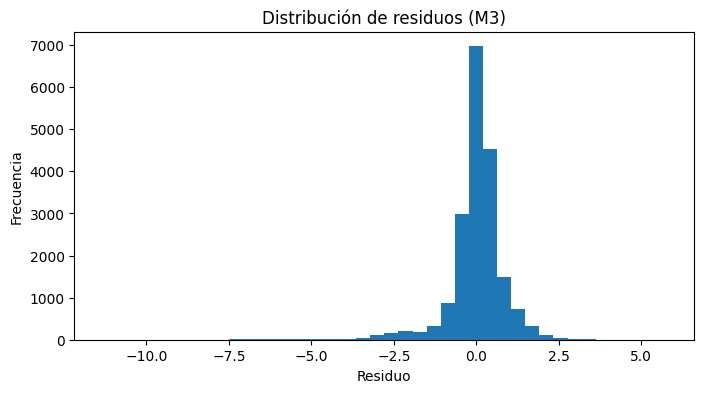

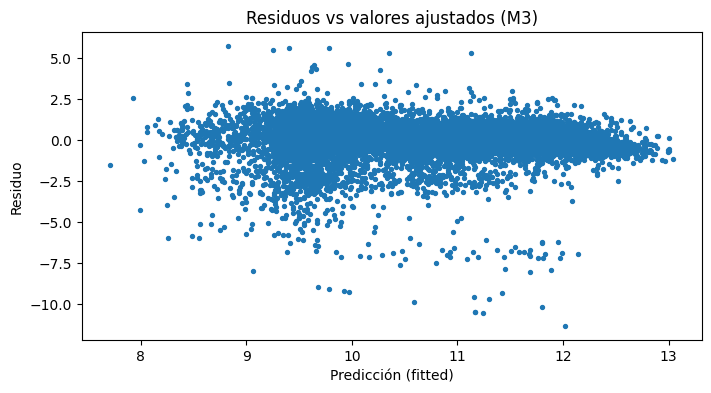

In [37]:
import matplotlib.pyplot as plt

resid = m3.resid

plt.figure(figsize=(8,4))
plt.hist(resid, bins=40)
plt.title("Distribución de residuos (M3)")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(m3.fittedvalues, resid, s=8)
plt.title("Residuos vs valores ajustados (M3)")
plt.xlabel("Predicción (fitted)")
plt.ylabel("Residuo")
plt.show()


In [38]:
remote_effects(m3)


,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.196839,21.754806,17.198676,26.488057,4.708597e-24
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.290031,33.646931,28.001943,39.540866,1.271971e-39


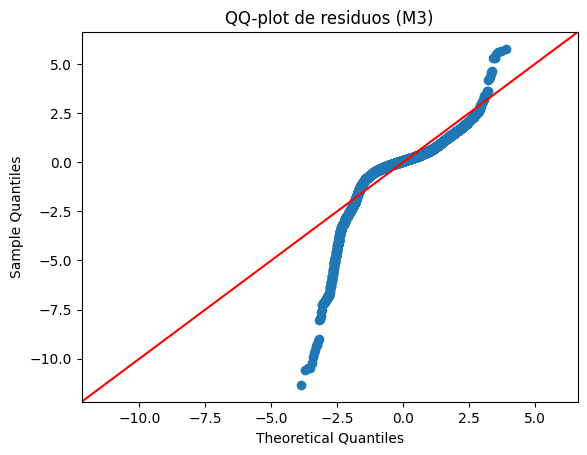

In [48]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

sm.qqplot(m3.resid, line="45")
plt.title("QQ-plot de residuos (M3)")
plt.show()

Conclusión formal de RQ2 (para informe)

RQ2: ¿Se mantiene la asociación entre RemoteWork y salario al controlar por país, experiencia, educación y rol?

Modelo y especificación

Para evaluar la asociación ajustada entre modalidad de trabajo y salario, se ajustó un modelo de regresión lineal (OLS) con variable dependiente log_salary = log(1 + ConvertedCompYearly). La variable principal fue RemoteWork (categorías: In-person [referencia], Hybrid, Remote). Como covariables de control se incluyeron: experiencia profesional (YearsCodePro_num), educación (EdLevel), rol (DevType) y país (Country). Se utilizaron errores estándar robustos (HC3) para mitigar el impacto de heterocedasticidad esperable en datos salariales.

Resultados principales (modelo final M3)

En el modelo ajustado (M3), tomando In-person como referencia:

Hybrid vs In-person: coeficiente en escala log β = 0.1968, lo que corresponde a un efecto aproximado de +21.8% en salario anual (IC95%: 17.2% a 26.5%, p ≪ 0.001).

Remote vs In-person: β = 0.2900, equivalente a +33.6% (IC95%: 28.0% a 39.5%, p ≪ 0.001).

Estos intervalos de confianza son completamente positivos, lo que indica que, bajo esta especificación, tanto el trabajo híbrido como el totalmente remoto se asocian con salarios anuales mayores que el trabajo presencial, incluso después de controlar por país, experiencia, educación y rol.

Comparación con modelos no ajustados (evidencia de “se mantiene”)

Al comparar la secuencia de modelos M0→M3, el efecto crudo observado en M0 (~+55% para Hybrid/Remote vs In-person) se reduce al introducir controles, especialmente al incorporar Country. Esto sugiere que parte de la asociación cruda se explica por diferencias de composición (por ejemplo, países y perfiles ocupacionales con salarios distintos). Sin embargo, dado que los efectos permanecen positivos y sustanciales en M3, se concluye que la asociación entre RemoteWork y salario se mantiene tras el ajuste, aunque con magnitud menor que la observada en el análisis crudo.

Diagnósticos y consideraciones del modelo (para sección de supuestos/limitaciones)

Completitud de datos: al exigir controles completos se eliminó ~3.24% de filas. La pérdida no fue completamente aleatoria respecto a RemoteWork (chi-cuadrado significativo), aunque el cambio de proporciones por modalidad fue moderado. Esto se reporta como posible fuente menor de sesgo de selección.

Heterocedasticidad y outliers: los gráficos de residuos (histograma y residuos vs ajustados) muestran dispersión no perfectamente constante y presencia de valores extremos, patrones esperables en datos salariales. En el QQ-plot se observan desviaciones de normalidad en las colas (colas pesadas). Para robustecer la inferencia se usaron errores estándar robustos HC3, y se trabajó con log_salary para reducir la influencia de outliers.

Robustez respecto a roles raros: se inspeccionaron roles con baja frecuencia y se probó agruparlos; los coeficientes de RemoteWork en M3 cambiaron de forma despreciable, lo que sugiere que los resultados no dependen de la codificación de roles poco frecuentes.